In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# Get Data (Prepare many batches of data)

In [2]:
import VP_oscillator_predictor as VPs
import matplotlib.pyplot as plt

In [3]:
params={'a':2,
        'b':-0.8,
        'c':2,
        'd':-10,
        'delta_t':0.01}
Predictor=VPs.VP_O(params)

In [4]:
DATA={}
batch_num=100
T=100

for i in np.arange(batch_num):
    if i<20:
        u=np.cos([i*np.pi/T for i in range(T)])
    else:
        u=np.cos([i*np.pi/T for i in range(T)])
    x0,y0=np.random.random_sample(1)[0],np.random.random_sample(1)[0]
    x,y=Predictor.sim(x0,y0,T,u)
    DATA[i]={'x':x,'y':y,'u':u}

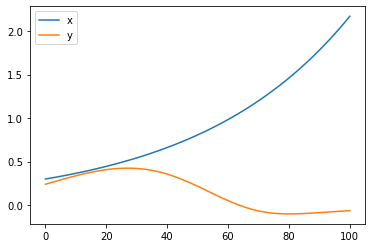

In [5]:
plt.plot(DATA[0]['x'],label='x')
plt.plot(DATA[0]['y'],label='y')
plt.legend()

In [6]:
index=0
X_train=np.concatenate((DATA[index]['x'][0:-1].reshape((-1,1)),DATA[index]['y'][0:-1].reshape((-1,1))),axis=1)
Y_train=np.concatenate((DATA[index]['x'][1:].reshape((-1,1)),DATA[index]['y'][1:].reshape((-1,1))),axis=1)
X_train_F=DATA[index]['u'].reshape((-1,1))
print(X_train.shape,Y_train.shape,X_train_F.shape)

(100, 2) (100, 2) (100, 1)


# Define model (Consider sever steps)

In [7]:
def weight_variable(shape, var_name, distribution='tn', scale=0.1):
    if distribution == 'tn':
        initial = tf.compat.v1.truncated_normal(shape, stddev=scale, dtype=tf.float64)
    elif distribution == 'xavier':
        scale = 4 * np.sqrt(6.0 / (shape[0] + shape[1]))
        initial = tf.compat.v1.random_uniform(shape, minval=-scale, maxval=scale, dtype=tf.float64)
    elif distribution == 'dl':
        # see page 295 of Goodfellow et al's DL book
        # divide by sqrt of m, where m is number of inputs
        scale = 1.0 / np.sqrt(shape[0])
        initial = tf.compat.v1.random_uniform(shape, minval=-scale, maxval=scale, dtype=tf.float64)
    elif distribution == 'he':
        # from He, et al. ICCV 2015 (referenced in Andrew Ng's class)
        # divide by m, where m is number of inputs
        scale = np.sqrt(2.0 / shape[0])
        initial = tf.compat.v1.random_normal(shape, mean=0, stddev=scale, dtype=tf.float64)
    elif distribution == 'glorot_bengio':
        # see page 295 of Goodfellow et al's DL book
        scale = np.sqrt(6.0 / (shape[0] + shape[1]))
        initial = tf.compat.v1.random_uniform(shape, minval=-scale, maxval=scale, dtype=tf.float64)
    else:
        initial = np.loadtxt(distribution, delimiter=',', dtype=np.float64)
        if (initial.shape[0] != shape[0]) or (initial.shape[1] != shape[1]):
            raise ValueError(
                'Initialization for %s is not correct shape. Expecting (%d,%d), but find (%d,%d) in %s.' % (
                    var_name, shape[0], shape[1], initial.shape[0], initial.shape[1], distribution))
    return tf.Variable(initial, name=var_name)


def bias_variable(shape, var_name, distribution=''):
    if distribution:
        initial = np.genfromtxt(distribution, delimiter=',', dtype=np.float64)
    else:
        initial = tf.compat.v1.constant(0.0, shape=shape, dtype=tf.float64)
    return tf.Variable(initial, name=var_name)

In [8]:
class Test_net():
    def __init__(self,params):
        super(Test_net, self).__init__()
        tf.compat.v1.disable_eager_execution()
        self.params=params
        x_in,f_in=self.params['input_layer'],self.params['input_f_layer']
        time_steps=self.params['step']
        self.x = tf.compat.v1.placeholder(tf.float64, [None, x_in])
        self.f = tf.compat.v1.placeholder(tf.float64, [None, f_in])
        self.y = tf.compat.v1.placeholder(tf.float64, [None, x_in])
        
        self.weights = dict()
        self.biases = dict()
        self.encoding_layer()
        self.forcing_layer()
        self.feature_layer()
        self.decoding_layer()
        self.K_layer()
        
    def encoding_layer(self):
        widths=self.params['encoder_layer']#width be like [[2,3],[3,4]]
        for i in np.arange(len(widths)):
            self.weights['WE%d' % (i)] = weight_variable([widths[i][0], widths[i][1]], var_name='WE%d' % (i))
            self.biases['bE%d' % (i)] = bias_variable([widths[i][1], ], var_name='bE%d' % (i))

    def forcing_layer(self):
        widths=self.params['forcing_layer']#width be like [[2,3],[3,4]]
        for i in np.arange(len(widths)):
            self.weights['Wf%d' % (i)] = weight_variable([widths[i][0], widths[i][1]], var_name='Wf%d' % (i))
            self.biases['bf%d' % (i)] = bias_variable([widths[i][1], ], var_name='bf%d' % (i))
            
    def feature_layer(self):
        widths=self.params['feature_layer']#width be like [[2,3],[3,4]]
        for i in np.arange(len(widths)):
            self.weights['Wfe%d' % (i)] = weight_variable([widths[i][0], widths[i][1]], var_name='Wfe%d' % (i))
            self.biases['bfe%d' % (i)] = bias_variable([widths[i][1], ], var_name='bfe%d' % (i))

    def decoding_layer(self):
        widths=self.params['decoder_layer']#width be like [[2,3],[3,4]]
        for i in np.arange(len(widths)):
            self.weights['WD%d' % (i)] = weight_variable([widths[i][0], widths[i][1]], var_name='WD%d' % (i))
            self.biases['bD%d' % (i)] = bias_variable([widths[i][1], ], var_name='bD%d' % (i))
            
    def K_layer(self):
        widths=self.params['K_layer']#width be like [[2,3],[3,4]]
        for i in np.arange(len(widths)):
            self.weights['WK%d' % (i)] = weight_variable([widths[i][0], widths[i][1]], var_name='WK%d' % (i))
            self.biases['bK%d' % (i)] = bias_variable([widths[i][1], ], var_name='bK%d' % (i))
    
    '''
    Apply net#################################################################################################################
    '''
    
    def encoder_apply(self,prev_layer):
        #prev_layer=self.x
        with tf.compat.v1.variable_scope('encoder',reuse=tf.compat.v1.AUTO_REUSE):
            widths=self.params['encoder_layer']
            for i in np.arange(len(widths)-1):
                prev_layer = tf.nn.relu(tf.matmul(prev_layer, self.weights['WE%d' % (i)]) + self.biases['bE%d' % (i)])
            return tf.matmul(prev_layer, self.weights['WE%d' % (len(widths)-1)]) + self.biases['bE%d' % (len(widths)-1)]
    
    def force_apply(self,prev_layer):
        #prev_layer=self.f
        with tf.compat.v1.variable_scope('forcing',reuse=tf.compat.v1.AUTO_REUSE):
            widths=self.params['forcing_layer']
            for i in np.arange(len(widths)-1):
                prev_layer = tf.nn.relu(tf.matmul(prev_layer, self.weights['Wf%d' % (i)]) + self.biases['bf%d' % (i)])
            return tf.matmul(prev_layer, self.weights['Wf%d' % (len(widths)-1)]) + self.biases['bf%d' % (len(widths)-1)]
    
    def feature_apply(self,x_encoder,f_encoder):
        #self.x_encoder,self.f_encoder
        with tf.compat.v1.variable_scope('feature',reuse=tf.compat.v1.AUTO_REUSE):
            prev_layer=tf.concat([x_encoder,f_encoder],axis=1)
            widths=self.params['feature_layer']
            for i in np.arange(len(widths)-1):
                prev_layer = tf.nn.relu(tf.matmul(prev_layer, self.weights['Wfe%d' % (i)]) + self.biases['bfe%d' % (i)])
            return tf.matmul(prev_layer, self.weights['Wfe%d' % (len(widths)-1)]) + self.biases['bfe%d' % (len(widths)-1)]
    
    def K_apply(self,prev_layer):
        with tf.compat.v1.variable_scope('K_net',reuse=tf.compat.v1.AUTO_REUSE):
            widths=self.params['K_layer']
            for i in np.arange(len(widths)-1):
                prev_layer = tf.nn.relu(tf.matmul(prev_layer, self.weights['WK%d' % (i)]) + self.biases['bK%d' % (i)])
            omegas=tf.matmul(prev_layer, self.weights['WK%d' % (len(widths)-1)]) + self.biases['bK%d' % (len(widths)-1)]
            
            #use omega to construct matrix K
            delta_t=self.params['deltt']
            scale = tf.exp(omegas[:, 1] * delta_t)
            entry11 = tf.multiply(scale, tf.cos(omegas[:, 0] * delta_t))
            entry12 = tf.multiply(scale, tf.sin(omegas[:, 0] * delta_t))
            row1 = tf.stack([entry11, -entry12], axis=1)  # [None, 2]
            row2 = tf.stack([entry12, entry11], axis=1)  # [None, 2]
            return tf.stack([row1, row2], axis=2)  # [None, 2, 2] put one row below other
     
    def advance_apply(self,feature,K,steps):
        with tf.compat.v1.variable_scope('advance',reuse=tf.compat.v1.AUTO_REUSE):
            y=[]
            for step in np.arange(steps):
                ystack = tf.reshape(feature[step],(1,self.params['input_layer']))
                Kstack = K[step]
                y.append(tf.matmul(ystack,Kstack))
            return tf.concat(y,axis=0)
    
    def decoder_apply(self,prev_layer):
        #prev_layer=self.x_adv
        with tf.compat.v1.variable_scope('decoder',reuse=tf.compat.v1.AUTO_REUSE):
            widths=self.params['decoder_layer']
            for i in np.arange(len(widths)-1):
                prev_layer = tf.nn.relu(tf.matmul(prev_layer, self.weights['WD%d' % (i)]) + self.biases['bD%d' % (i)])
            #self.y = 
            return tf.matmul(prev_layer, self.weights['WD%d' % (len(widths)-1)]) + self.biases['bD%d' % (len(widths)-1)]
    
    def forward_net(self,x,f,steps):
        #For only one step
        x_en=self.encoder_apply(x)
        f_en=self.force_apply(f)
        feature=self.feature_apply(x_en,f_en)
        K=self.K_apply(feature)
        x_adv=self.advance_apply(feature,K,steps)
        y=self.decoder_apply(x_adv)
        return y 
    
    def loss1(self,x,f,y):
        with tf.compat.v1.variable_scope('loss1',reuse=tf.compat.v1.AUTO_REUSE):
            return tf.reduce_mean(tf.square(self.forward_net(x,f,self.params['step'])-y))
    
    def loss2(self,x):
        with tf.compat.v1.variable_scope('loss2',reuse=tf.compat.v1.AUTO_REUSE):
            x_en=self.encoder_apply(x)
            x_de=self.decoder_apply(x_en)
            return tf.reduce_mean(tf.square(x_de-x))
    
    def loss3(self,x,f,y):     
        with tf.compat.v1.variable_scope('loss3',reuse=tf.compat.v1.AUTO_REUSE):
            x_en=self.encoder_apply(x)
            f_en=self.force_apply(f)
            feature=self.feature_apply(x_en,f_en)
            K=self.K_apply(feature)
            x_adv=self.advance_apply(feature,K,self.params['step'])
            y_en=self.encoder_apply(y)
            return tf.reduce_mean(tf.square(y_en-x_adv))
    
    def loss4(self,x,f,y):
        xt=tf.reshape(x[0],(1,self.params['input_layer']))
        with tf.compat.v1.variable_scope('loss4',reuse=tf.compat.v1.AUTO_REUSE):
            N,m=y.shape
            err_bar=[]
            for i in np.arange(self.params['step']):
                ft=tf.reshape(f[i],(1,self.params['input_f_layer']))
                x_en=self.encoder_apply(xt)
                f_en=self.force_apply(ft)
                feature=self.feature_apply(x_en,f_en)
                K=self.K_apply(feature)
                x_adv=self.advance_apply(feature,K,1)
                y_bar=self.decoder_apply(x_adv)
                err_bar.append(y_bar-y[i])
                xt=y_bar
            return tf.reduce_mean(tf.square(err_bar))
        
    def Loss(self,x,f,y): 
        loss1=self.loss1(x,f,y)
        loss2=self.loss2(x)
        loss3=self.loss3(x,f,y)
        loss4=self.loss4(x,f,y)
        with tf.compat.v1.variable_scope('Loss',reuse=tf.compat.v1.AUTO_REUSE):
            self.Loss=loss4+loss2+loss1+loss3
    
    def opt(self):
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=self.params['lr'])
        self.train_op = self.optimizer.minimize(self.Loss)



# Training data

In [9]:
params={}
params['step']=X_train.shape[0]
params['encoder_layer']=[[X_train.shape[1],30],[30,15],[15,2]]
params['decoder_layer']=[[2,15],[15,30],[30,X_train.shape[1]]]
params['feature_layer']=[[2+2,10],[10,2]]
params['forcing_layer']=[[1,2]]
params['K_layer']=[[2,2]]
params['input_layer']=X_train.shape[1]
params['input_f_layer']=X_train_F.shape[1]
params['lr']=0.0001
params['deltt']=0.01

model=Test_net(params)
model.Loss(model.x,model.f,model.y)
model.opt()

In [10]:
sess=tf.compat.v1.Session()
init_op = tf.compat.v1.global_variables_initializer()
sess.run(init_op)
saver = tf.compat.v1.train.Saver()
r1,r2=[],[]

In [11]:
epoch=6000
BATCH_NUM=1
for step in np.arange(epoch):
    if np.mod(step,50)==0 and step!=0:
        saver.save(sess, "model/model.ckpt")
    for index in np.arange(BATCH_NUM):
        X_train=np.concatenate((DATA[index]['x'][0:-1].reshape((-1,1)),DATA[index]['y'][0:-1].reshape((-1,1))),axis=1)
        Y_train=np.concatenate((DATA[index]['x'][1:].reshape((-1,1)),DATA[index]['y'][1:].reshape((-1,1))),axis=1)
        X_train_F=DATA[index]['u'].reshape((-1,1))
        sess.run(model.train_op,feed_dict={model.x:X_train,model.y:Y_train,model.f:X_train_F})
    r1.append(sess.run(model.Loss,feed_dict={model.x:X_train,model.y:Y_train,model.f:X_train_F}))
    #r2.append(sess.run(model.Loss,feed_dict={model.x:X_test,model.y_bar:Y_test,model.f:X_test_F}))

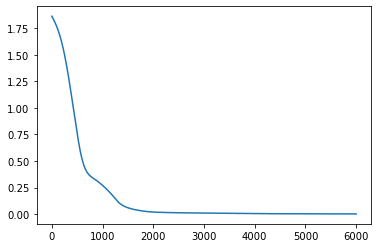

In [12]:
plt.plot(r1)

In [13]:
np.min(r1)

0.0012603970890667205

# Test

In [14]:
x = tf.compat.v1.placeholder(tf.float64, [1, params['input_layer']])
f = tf.compat.v1.placeholder(tf.float64, [1, params['input_f_layer']])
y_bar=model.forward_net(x,f,1)

(100, 2) (100, 2) (100, 1)
(100, 2)


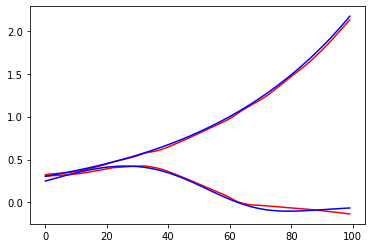

In [18]:
index=1
X_test=np.concatenate((DATA[index]['x'][0:-1].reshape((-1,1)),DATA[index]['y'][0:-1].reshape((-1,1))),axis=1)
Y_test=np.concatenate((DATA[index]['x'][1:].reshape((-1,1)),DATA[index]['y'][1:].reshape((-1,1))),axis=1)
X_test_F=DATA[index]['u'].reshape((-1,1))
print(X_test.shape,Y_test.shape,X_test_F.shape)

X,Y,XF=X_train[0].reshape((1,-1)),Y_train,X_train_F[0].reshape((1,-1))
y_=[]
for t in np.arange(params['step']):
    ytem=sess.run(y_bar,feed_dict={x:X,f:XF})
    y_.append(ytem.tolist()[0])
    X=ytem
    XF=X_test_F[t].reshape((1,-1))
y_reg=np.array(y_)
plt.plot(y_reg,'r')
print(y_reg.shape)
plt.plot(Y,'b')

In [19]:
y_bbar=model.forward_net(model.x,model.f,params['step'])

(100, 2) (100, 2) (100, 1)


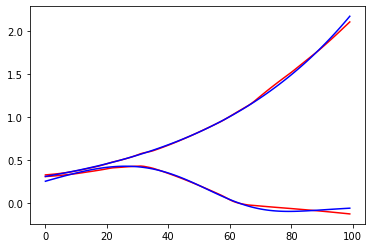

In [22]:
X,Y,XF=X_train,Y_train,X_train_F
print(X.shape,Y.shape,XF.shape)
y_=sess.run(y_bbar,feed_dict={model.x:X,model.f:XF})
plt.plot(y_,'r')
plt.plot(Y,'b')

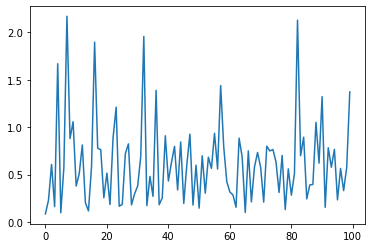

In [403]:
ers=[]

for index in np.arange(100):
    X_test=np.concatenate((DATA[index]['x'][0:-1].reshape((-1,1)),DATA[index]['y'][0:-1].reshape((-1,1))),axis=1)
    Y_test=np.concatenate((DATA[index]['x'][1:].reshape((-1,1)),DATA[index]['y'][1:].reshape((-1,1))),axis=1)
    X_test_F=DATA[index]['u'].reshape((-1,1))
    
    X,Y,XF=X_test,Y_test,X_test_F
    x0,u0=X_test[0].reshape((1,-1)),X_test_F[0].reshape((1,-1))
    y_reg=[]
    for t in np.arange(X_test_F.shape[0]):
        y_=sess.run(y_bar,feed_dict={model.x:x0,model.f:u0})
        x0,u0=y_,X_test_F[t].reshape((1,-1))
        y_reg.append(y_.tolist()[0])
    y_reg=np.array(y_reg)
    ers.append(np.mean(np.abs(y_reg-Y)))
plt.plot(ers)

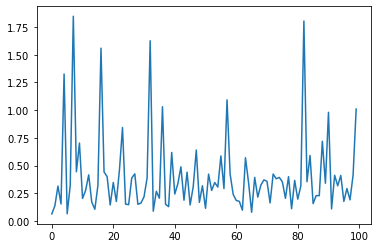

In [404]:
ers=[]

for index in np.arange(100):
    X_test=np.concatenate((DATA[index]['x'][0:-1].reshape((-1,1)),DATA[index]['y'][0:-1].reshape((-1,1))),axis=1)
    Y_test=np.concatenate((DATA[index]['x'][1:].reshape((-1,1)),DATA[index]['y'][1:].reshape((-1,1))),axis=1)
    X_test_F=DATA[index]['u'].reshape((-1,1))
    
    X,Y,XF=X_test,Y_test,X_test_F
    y_reg=sess.run(y_bar,feed_dict={model.x:X,model.f:XF})
    ers.append(np.mean(np.abs(y_reg-Y)))
plt.plot(ers)

# Looks Good!!!!

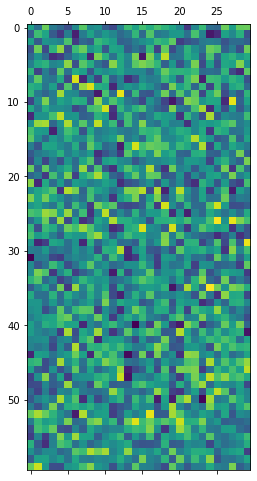

In [405]:
K=sess.run(model.K)
plt.matshow(K)

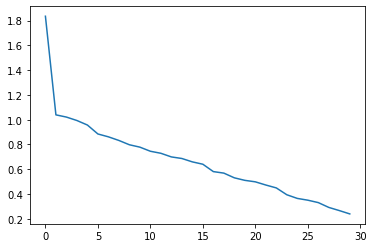

In [406]:
u,sigma,v=np.linalg.svd(K)
plt.plot(sigma)